In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
def vis(t: torch.Tensor, label=''):
    data = t.detach().numpy()
    data = data.round(3)
    df = pd.DataFrame(columns=data) if t.ndim == 1 else pd.DataFrame(data)
    df.columns.name = label+':'
    # df = df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'normal')]}])
    display(df)

vis(torch.rand(7))

:,0.205,0.364,0.400,0.802,0.693,0.822,0.006


In [3]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)} words')
print(f'min word length: {min(len(w) for w in words)}')
print(f'max word length: {max(len(w) for w in words)}')
print(words[:10])

32033 words
min word length: 2
max word length: 15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

vis(Xtr)
vis(Ytr)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


:,0,1,2
0,0,0,0
1,0,0,25
2,0,25,21
3,25,21,8
4,21,8,5
...,...,...,...
182620,0,8,15
182621,8,15,12
182622,15,12,4
182623,12,4,1


:,25,21,8,5,14,7,0,4,9,15,...,5,12,0,8,15,12,4,1,14,0


In [6]:
train_ds = TensorDataset(Xtr, Ytr)
len(train_ds)

182625

In [7]:
epochs = 200
epochs_list, train_losses, dev_losses = [], [], []
parameters, ud = [], []

def do_plot():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    l1, = ax1.plot(epochs_list, train_losses, label='train')
    l2, = ax1.plot(epochs_list, dev_losses, label='dev')
    ax1.legend()
    ax1.set_xlabel('EPOCH')
    ax1.set_ylabel('LOSS')
    ax1.set_xlim(-5, epochs + 5)
    ax1.set_ylim(1.9, 2.5)

    legends = []
    pps = [None] * len(parameters)
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            pps[i], = ax2.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    ax2.plot([0, epochs], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    ax2.set_xlabel('EPOCH')
    ax2.set_ylabel('WEIGHTS UPDATE RATIO')
    ax2.set_xlim(-5, epochs + 5)
    ax2.set_ylim(-8, 2)
    ax2.legend(legends);

    plt.show()
    return fig, ax1, l1, l2, ax2, pps

# do_plot()

In [8]:
def update_plot(title):
    l1.set_data(epochs_list, train_losses)
    l2.set_data(epochs_list, dev_losses)
    ax1.set_title(title)

    for i,p in enumerate(parameters):
        if p.ndim == 2:
            pps[i].set_data(epochs_list, [ud[j][i] for j in range(len(ud))])

    clear_output(wait=True)
    display(fig)

In [9]:
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=False):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [10]:
def model(inputs):
    global bnmean_running, bnstd_running
    emb = C[inputs]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    return x

def model_inf(inputs):
    for layer in layers: layer.training = False
    x = model(inputs)
    for layer in layers: layer.training = True
    return x

def do_loss(inputs, targets):
    return F.cross_entropy(model(inputs), targets)

@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  for layer in layers: layer.training = False
  loss = do_loss(x, y)
  for layer in layers: layer.training = True
  return loss.item()

In [11]:
vocab_size = len(itos)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
torch.manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  # for layer in layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'NN params: {sum(p.nelement() for p in parameters)}')
for p in parameters:
  p.requires_grad = True

epochs = 1 + 150
lrs = np.linspace(0.05, 0.02, epochs)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
batches = len(train_dl)
print(f'mini batches: {batches}')
batches_cut = int(batches * 0.7)
print(f'effective batches: {batches_cut}')

NN params: 47024
mini batches: 2854
effective batches: 1997


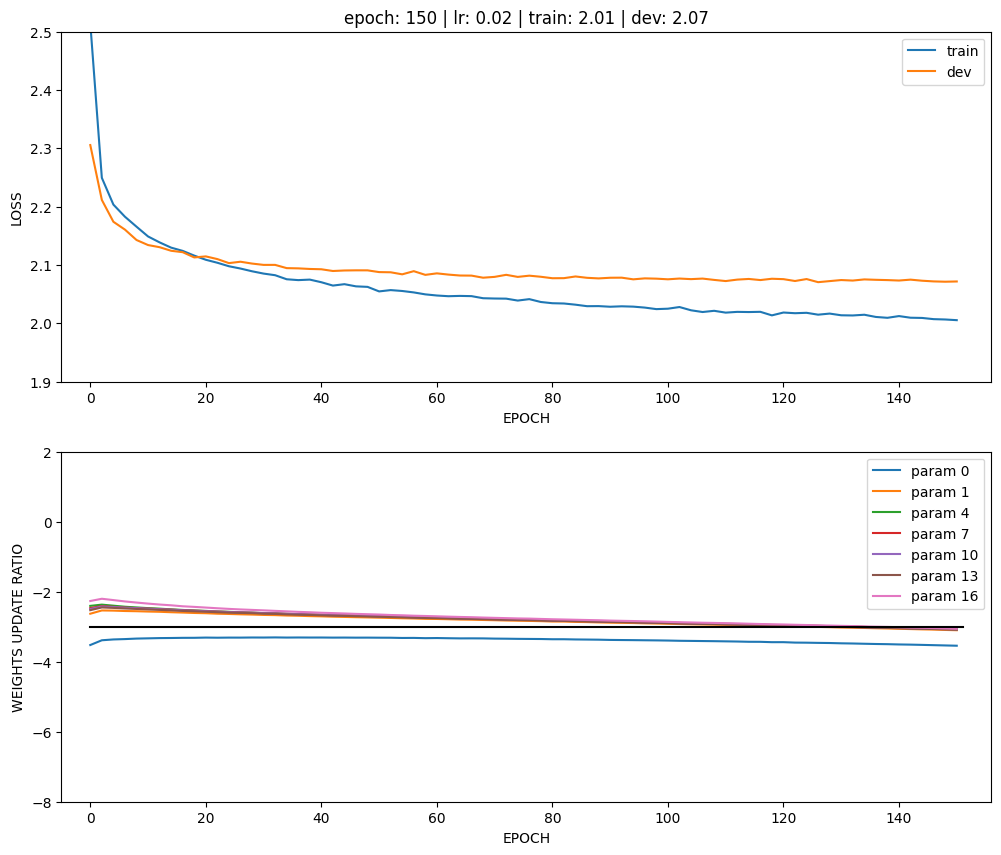

In [12]:
plt.ion()
epochs_list, train_losses, dev_losses, ud = [], [], [], []
fig, ax1, l1, l2, ax2, pps = do_plot()

for epoch in range(epochs):
  bloss = 0.0
  buds = pd.DataFrame()
  for i, (inputs, targets) in enumerate(train_dl):
    # forward pass
    loss = do_loss(inputs, targets)
    bloss += loss.item()

    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters: p.grad = None
    loss.backward()
    
    # update
    lr = lrs[epoch]
    for p in parameters: p.data -= lr * p.grad

    if i >= batches_cut: break

    with torch.no_grad():
      budi = [((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]
      buds = pd.concat([buds, pd.DataFrame([budi])], ignore_index=True)

  # printout
  if True and epoch % 2 == 0:
    epochs_list.append(epoch)
    ud.append(buds.mean(axis=0).to_numpy())
    train_losses.append(bloss/batches_cut)
    dev_losses.append(split_loss('val'))
    update_plot(f"epoch: {epoch:3d} | lr: {lr:.2f} | train: {train_losses[-1]:.2f} | dev: {dev_losses[-1]:.2f}")

  # break

plt.ioff()

layer 2 (      Tanh): mean +0.00, std 0.69, saturated: 14.39%
layer 5 (      Tanh): mean -0.00, std 0.72, saturated: 16.16%
layer 8 (      Tanh): mean +0.00, std 0.75, saturated: 16.20%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 18.09%
layer 14 (      Tanh): mean -0.00, std 0.81, saturated: 23.63%


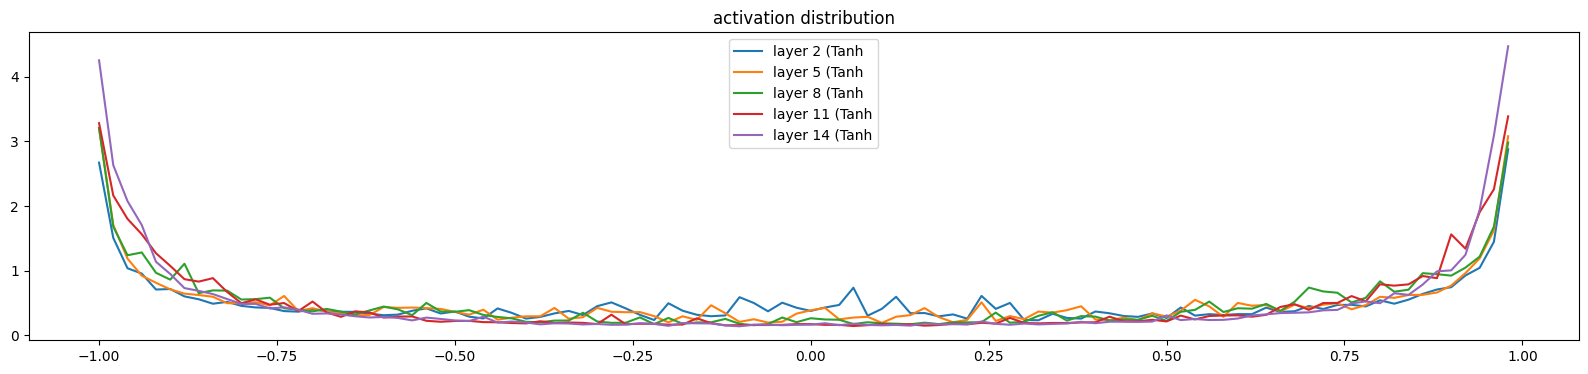

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

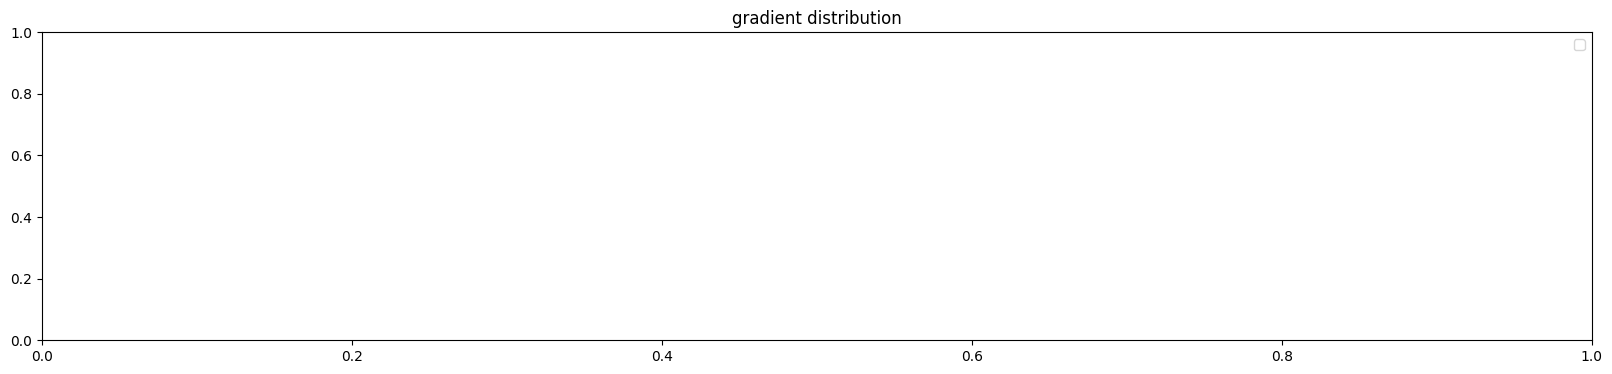

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    if t is None: continue
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean +0.000000 | std 0.013816 | grad:data ratio 0.013417
weight  (30, 100) | mean +0.000054 | std 0.011328 | grad:data ratio 0.038541
weight (100, 100) | mean +0.000161 | std 0.007584 | grad:data ratio 0.040804
weight (100, 100) | mean -0.000028 | std 0.007438 | grad:data ratio 0.040804
weight (100, 100) | mean -0.000011 | std 0.007512 | grad:data ratio 0.041968
weight (100, 100) | mean +0.000010 | std 0.007288 | grad:data ratio 0.042313
weight  (100, 27) | mean +0.000166 | std 0.012254 | grad:data ratio 0.048017


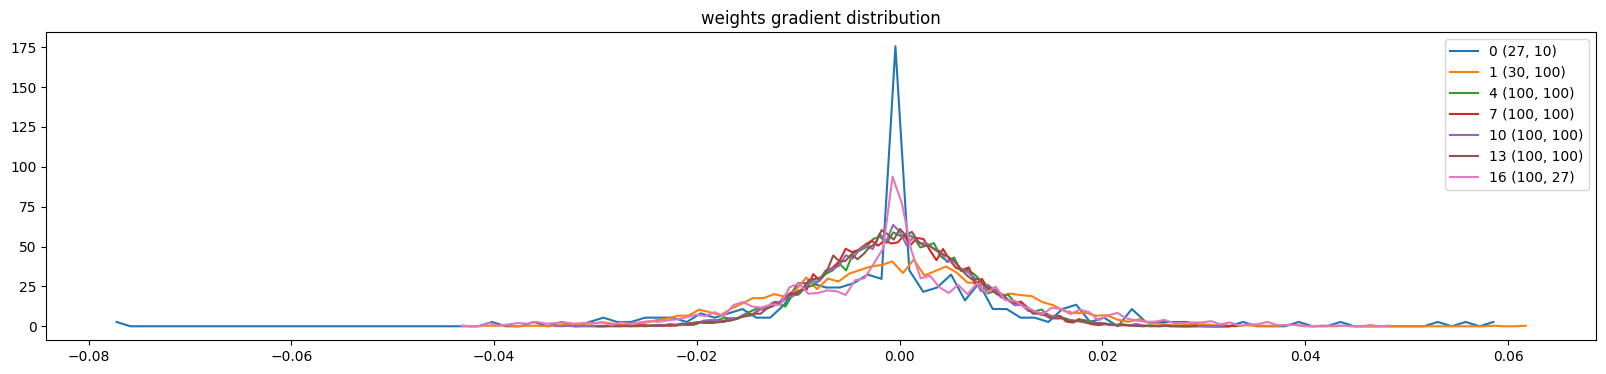

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %f | grad:data ratio %3f' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

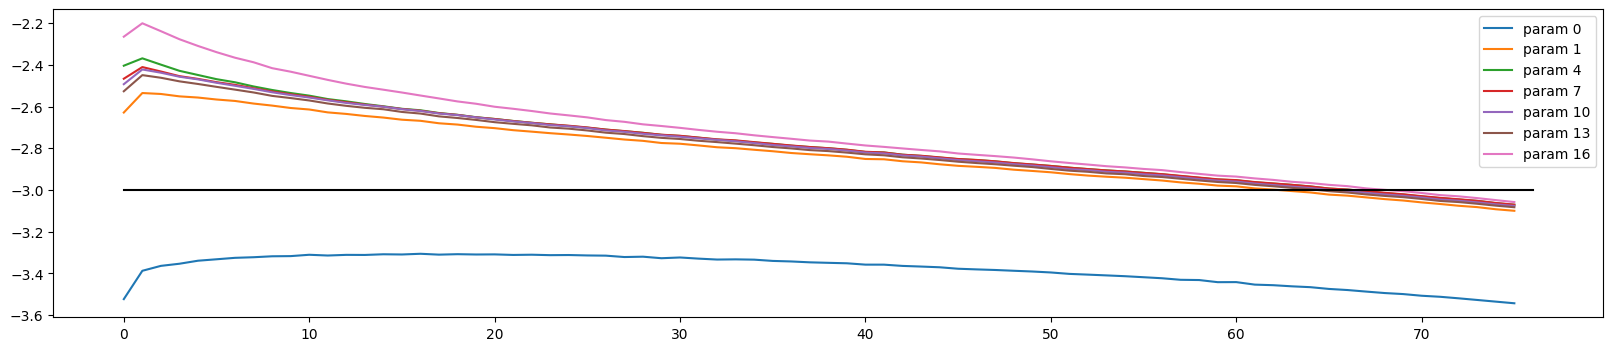

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()

In [17]:
# sample from the model
torch.manual_seed(42)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      inputs = torch.tensor([context])
      logits = model_inf(inputs)
      # print(logits)
      probs = logits.softmax(1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

anuellyn.
jamar.
idustyn.
shawn.
kalynn.
arthan.
lucin.
epicco.
den.
dmon.
kend.
josey.
goddela.
makylynn.
acvahia.
acen.
kaithan.
tiyan.
mar.
tal.
